#### Variational Inference with dynamic Βayesian Gaussian process latent variation model with gpytorch

In this tutorial, I am going show how to build a dynamic Βayesian Gaussian process latent variation modelfor psychological measurement problem. We approximate the latent vectors with variational distributions and the response function mapping using the Gaussian process framework,  a family of non-parametric methods that enable flexible modeling of the mappings. Since the complexity of training Gaussian process model scales cubicly in time and squarely in storage, we adopt a [sparse Gaussian process approach](http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf) based on a small set of inducing points. Our tutorial is based on [gpytorch](https://gpytorch.ai/), an efficient and user-friendly implementation of Gaussian process models in python. 

In [5]:
# loading packages
import numpy as np
import matplotlib.pylab as plt
import torch
import os
import gpytorch
from gpytorch.mlls import VariationalELBO

from scipy.stats import norm
torch.manual_seed(8927)
np.random.seed(8927)
torch.set_default_dtype(torch.float64)

import warnings
warnings.filterwarnings("ignore")

from gpytorch.models import ApproximateGP
from gpytorch.mlls import VariationalELBO
from gpytorch.priors import NormalPrior, MultivariateNormalPrior
from gpytorch.likelihoods import BernoulliLikelihood
from gpytorch.variational import VariationalStrategy
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.kernels import LinearKernel, RBFKernel, ScaleKernel
from gpytorch.distributions import MultivariateNormal
from torch.nn import ModuleList

The problem setting is exactly the same as the other tutorial [Variational Inference with dynamic latent variable model with pyro](https://github.com/yahoochen97/GP-Idiographic-Measurement/blob/main/dynanmic_lvm.ipynb).

In [8]:
# generate synthetic data
n = 20
m = 10
horizon = 15
latent_dim = 1

true_slope = np.concatenate((np.random.normal(2,0.5,size=(m//2,1)),
                    np.random.normal(-2,0.5,size=(m//2,1)))).reshape(m,latent_dim)

x = torch.zeros((n, horizon))
x_cov = RBFKernel()
x_cov.lengthscale = horizon // 3 if horizon > 1 else 1
x_cov = x_cov(torch.arange(horizon)).evaluate()
for i in range(n):
    x[i] = (2*torch.bernoulli(torch.tensor(0.5))-1) + \
        MultivariateNormal(torch.zeros(horizon), x_cov+1e-6*torch.eye(horizon)).sample()

true_p = np.zeros((n, horizon, m))
for i in range(n):
    for j in range(m):
        true_p[i,:,j] = norm.cdf(true_slope[j] * x[i].numpy())
y = np.random.binomial(1, true_p)
y = torch.tensor(y).reshape((n*horizon,m))
print(y.shape)

torch.Size([300, 10])


The dynamic latent variables are implemented as a gpytorch module:

In [9]:
from gpytorch.module import Module
from gpytorch.mlls import KLGaussianAddedLossTerm

class DynamicLatentVariable(Module):
    """
    This super class is used to describe the type of inference
    used for the latent variable :math:`\\mathbf X` in GPLVM models.

    :param int n: Size of the latent space.
    :param int latent_dim: Dimensionality of latent space.
    """

    def __init__(self, n, horizon, dim):
        super().__init__()
        self.n = n
        self.latent_dim = dim
        self.horizon = horizon

    def forward(self, x):
        raise NotImplementedError
    
class VariationalDynamicLatentVariable(DynamicLatentVariable):
    """
    This class is used for dynamic GPLVM models to recover a variational approximation of
    the latent variable :math:`\\mathbf X`.

    :param int n: Size of the latent space.
    :param int data_dim: Dimensionality of the :math:`\\mathbf Y` values.
    :param int horizon: length of length series
    :param int latent_dim: Dimensionality of latent space.
    :param torch.Tensor X_init: initialization of :math:`\\mathbf X`, shape of n x (latent_dim*horizon)
    :param ~gpytorch.priors.Prior prior_x: prior for :math:`\\mathbf X`, shape of n x (latent_dim*horizon)
    """

    def __init__(self, n, data_dim, horizon, latent_dim, X_init, prior_x):
        super().__init__(n, horizon, latent_dim)
        self.data_dim = data_dim # m
        self.prior_x = prior_x

        # Local variational params per latent point with dimensionality latent_dim
        self.q_mu = torch.nn.Parameter(X_init) # n x (horizon*laten_dim)
        # K_dim = diag(v) + BB^T (v>0)
        self.q_dim_v = torch.nn.Parameter(torch.randn(latent_dim,1)) 
        self.q_dim_B = torch.nn.Parameter(torch.randn(latent_dim,1)) 
        self.q_time_var = torch.nn.Parameter(torch.ones(n,)) # diagonal K_t
        # This will add the KL divergence KL(q(X_i) || p(X_i)) to the loss
        for i in range(n):
            self.register_added_loss_term(f"x_{i}_kl")

    def forward(self):
        # Variational distribution over the latent variable q(x)
        results = torch.zeros((self.n, self.horizon*self.latent_dim))
        for i in range(self.n):
            # sigmoid for v so they are in the range of [0,1]
            # 2 sigmoid - 1 for B so they are in the range of [-1,1]
            tmp = 2*torch.sigmoid(self.q_dim_B) - 1
            K_dim = torch.matmul(tmp, tmp.t()) + \
                    torch.diag(torch.sigmoid(self.q_dim_v))
            # sigmoid for q_var so the variational variance are between 0 and 1
            K_t = torch.sigmoid(self.q_time_var[i]) * torch.eye(self.horizon)
            q_x = MultivariateNormal(self.q_mu[i], torch.kron(K_dim, K_t)\
                                     +1e-6*torch.eye(self.horizon*self.latent_dim))
            x_kl = KLGaussianAddedLossTerm(q_x, self.prior_x, 1, self.data_dim)
            self.update_added_loss_term(f"x_{i}_kl", x_kl)  # Update the KL term
            results[i] = q_x.rsample()
        return results


We extent [BGPLVM](https://docs.gpytorch.ai/en/stable/examples/045_GPLVM/Gaussian_Process_Latent_Variable_Models_with_Stochastic_Variational_Inference.html) to dynamic latent variable. We set the inducing point locations at an evenly spread grid from between -3 and 3. We assign normal priors to both response slope and the latent vectors.

In [10]:
from gpytorch.means import Mean

class LinearMeanWithPrior(Mean):
    def __init__(self, input_size, weights_prior=None, weights_constraint=None, batch_shape=torch.Size()):
        super().__init__()
        self.register_parameter(name="raw_weights", parameter=torch.nn.Parameter(torch.zeros(*batch_shape, input_size)))
        if weights_prior is not None:
            self.register_prior("weights_prior", weights_prior, self._weights_param, self._weights_closure)
        if weights_constraint is not None:
            self.register_constraint("raw_weights", weights_constraint)

    def forward(self, x):
        res = x.matmul(self.weights).squeeze(-1)
        return res
    
    @property
    def weights(self):
        return self._weights_param(self)

    @weights.setter
    def weights(self, value):
        self._weights_closure(self, value)

    def _weights_param(self, m):
        if hasattr(m, "raw_weights_constraint"):
            return m.raw_weights_constraint.transform(m.raw_weights)
        return m.raw_weights

    def _weights_closure(self, m, values):
        if not torch.is_tensor(values):
            value = torch.as_tensor(values).to(m.raw_weights)

        if hasattr(m, "raw_weights_constraint"):
            m.initialize(raw_weights=m.raw_weights_constraint.inverse_transform(values))
        else:
            m.initialize(raw_weights=values)

class GPIRT(ApproximateGP):
    def __init__(self, n, m, horizon, latent_dim, n_inducing, X_init):
        self.n = n # infer n*horizon latent variables 
        self.horizon = horizon # time series of length horizon
        self.batch_shape = torch.Size([m]) # infer m weights
        self.latent_dim = latent_dim

        # Locations Z_{d} corresponding to u_{d}
        self.inducing_inputs = torch.linspace(-3,3,n_inducing).t()
        # Sparse Variational Formulation
        q_u = CholeskyVariationalDistribution(n_inducing, batch_shape=self.batch_shape)
        q_f = VariationalStrategy(self, self.inducing_inputs, q_u, \
                                  learn_inducing_locations=False)
        super().__init__(q_f)

        # Define prior for X
        X_prior_mean = torch.zeros(horizon*latent_dim,)  # shape: 1 x Q
        X_prior_cov = RBFKernel()
        X_prior_cov.lengthscale = horizon // 3 if horizon > 1 else 1
        X_prior_cov = X_prior_cov(torch.arange(horizon)).evaluate() \
              + 4*torch.ones((horizon,horizon)) + 1e-6*torch.eye(horizon)
        X_prior_cov = torch.kron(torch.eye(latent_dim),X_prior_cov)
        prior_x = MultivariateNormalPrior(X_prior_mean, covariance_matrix=X_prior_cov)

        X = VariationalDynamicLatentVariable(n, m, horizon, latent_dim, X_init, prior_x)
        self.X = X

        # Kernel (acting on latent dimensions)
        self.mean_module = ModuleList([LinearMeanWithPrior(input_size=latent_dim, \
                        weights_prior=NormalPrior(0.,2.)) for _ in range(m)])
        self.covar_module = LinearKernel(ard_num_dims=latent_dim)
    
    def sample_latent_variable(self):
        sample = self.X()
        return sample

    def forward(self, X):
        m = len(self.mean_module)
        mean_x = torch.zeros((m, X.shape[0]))
        for j in range(m):
            mean_x[j] = self.mean_module[j](X)
        covar_x = self.covar_module(X).unsqueeze(0).repeat(m, 1, 1)
        dist = MultivariateNormal(mean_x, covar_x)
        return dist

    def _get_batch_idx(self, batch_size, iter):
        valid_indices = np.arange(self.n*self.horizon)
        iter_ = iter % (self.n*self.horizon//batch_size)
        batch_indices = valid_indices[(batch_size*iter_):(batch_size*iter_+batch_size)]
        return np.sort(batch_indices)

We set initialize the variational parameters to zero and use `Adam()` optimizer to learn the variational parameters.

In [31]:
n_inducing = 30
X_init = torch.nn.Parameter(torch.zeros((n,latent_dim*horizon)))

model = GPIRT(n, m, horizon, latent_dim, n_inducing, X_init)
likelihood = BernoulliLikelihood()

batch_size = n*horizon // 5
mll = VariationalELBO(likelihood, model, num_data=n*horizon*m)

# fix variance of prior on w to be 0.01.
hypers = {
'covar_module.variance': torch.tensor(0.1**2),
}

model.initialize(**hypers)
model.covar_module.raw_variance.requires_grad = False

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=0.1, betas=(0.9, 0.95))

# initial x/w with zero and MAP estimation
loss_list = []
n_steps = 2000
for iter in range(n_steps):
    batch_index = model._get_batch_idx(batch_size, iter)
    optimizer.zero_grad()
    sample = model.sample_latent_variable()  # a full sample returns latent x across all N
    sample_batch = sample.reshape((-1,1))[batch_index]
    output_batch = model(sample_batch)
    # manually iterate m questions
    loss = 0
    for j in range(m):
        output_batch_j = MultivariateNormal(output_batch.loc[j], output_batch.covariance_matrix[j])
        loss += -mll(output_batch_j, y[batch_index,j].T).sum()

    loss_list.append(loss.item())
    loss.backward(retain_graph=True)
    if iter % 50 == 0:
        print("Elbo loss: {} for {}/{}".format(loss, iter, n_steps))

    optimizer.step()


Elbo loss: 467737861.3097511 for 0/2000
Elbo loss: 2619569.201855554 for 50/2000
Elbo loss: 647650.7054953204 for 100/2000
Elbo loss: 212525.65347366614 for 150/2000
Elbo loss: 71125.47085885896 for 200/2000
Elbo loss: 33799.875565471506 for 250/2000
Elbo loss: 24839.267728120256 for 300/2000
Elbo loss: 19729.88053058464 for 350/2000
Elbo loss: 21252.78601638734 for 400/2000
Elbo loss: 19473.34226858105 for 450/2000
Elbo loss: 20696.26859627046 for 500/2000
Elbo loss: 18890.711585795732 for 550/2000
Elbo loss: 21028.09446759576 for 600/2000
Elbo loss: 19478.193757486377 for 650/2000
Elbo loss: 20022.698306531118 for 700/2000
Elbo loss: 20112.623492045364 for 750/2000
Elbo loss: 19994.862006522093 for 800/2000
Elbo loss: 21464.901793980313 for 850/2000
Elbo loss: 18988.770540107478 for 900/2000
Elbo loss: 18129.779332967242 for 950/2000
Elbo loss: 18152.818608701797 for 1000/2000
Elbo loss: 19006.54731537085 for 1050/2000
Elbo loss: 17161.44755635838 for 1100/2000
Elbo loss: 19404.08818

Visualize the VI loss

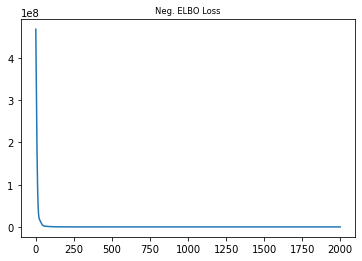

In [32]:
plt.plot(loss_list, label='VI loss')
plt.title('Neg. ELBO Loss', fontsize='small')
plt.show()

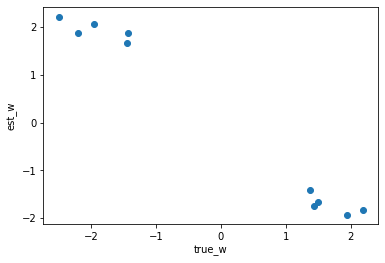

In [33]:
est_slopes = []
for i in range(m):
    # est_slopes.append(model.mean_weights.data[i])
    est_slopes.append(model.mean_module[i].weights.detach().data.tolist())
ratio =  np.std(true_slope) / np.std(est_slopes)

plt.scatter(true_slope, np.array(est_slopes)*ratio)
plt.xlabel("true_w")
plt.ylabel("est_w")
plt.show()

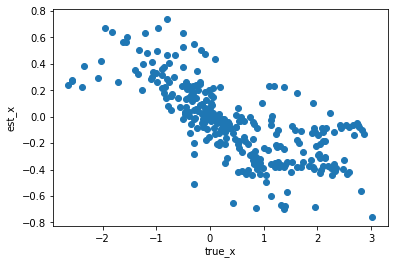

In [34]:
est_X = model.X.q_mu.detach().numpy()
plt.scatter(x, est_X/ratio)
plt.xlabel("true_x")
plt.ylabel("est_x")
plt.show()